<a href="https://colab.research.google.com/github/simhermansson/NLP_Yelp_Reviews/blob/main/NLP_Yelp_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Yelp Review Stars

### Read the two datasets to dataframes

We have one dataset for businesses, and one for reviews.
The businesses dataset is 113 MB, while the review dataset is almost 5 GB!

We must therefore be careful when loading that dataset to a dataframe to not run out of RAM.

In [ ]:
!pip install pandas --quiet
import pandas as pd

#from google.colab import drive


# Specify whether training final model or only using some of the data
FINAL_MODEL = False

# Mount Google Drive
#drive.mount("/content/drive")

# Read business data to dataframe
business_df = pd.read_json("/mnt/d/Datasets/yelp_academic_dataset_business.json",
                           lines=True)
# Keep only strictly necessary columns
business_df = business_df[["business_id", "stars", "review_count"]]

# Read review data to a JsonReader object, due to memory constraints
review_df = None
with pd.read_json("/mnt/d/Datasets/yelp_academic_dataset_review.json",
                  lines=True,
                  chunksize=1000000) as reader:
    # Keep only necessary columns and combine into a full dataframe
    for chunk in reader:
        chunk = chunk[["business_id", "stars", "text"]]
        review_df = chunk if review_df is None else pd.concat([review_df, chunk],
                                                              ignore_index=True)
    del chunk

# Use a smaller review dataset if not training the final model
if not FINAL_MODEL:
    review_df = review_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
# Create train and validation sets for the review data
train_review_df = review_df.sample(frac=0.8, random_state=42)
valid_review_df = review_df.drop(train_review_df.index).reset_index(drop=True)
train_review_df = train_review_df.reset_index(drop=True)
del review_df

#### Save the development train and test dataframes to avoid having to read the entire dataset every time.

In [ ]:
if not FINAL_MODEL:
    #train_review_df.to_csv("/content/drive/MyDrive/Colab Data/dev_train_review_df.csv", index=False)
    #valid_review_df.to_csv("/content/drive/MyDrive/Colab Data/dev_valid_review_df.csv", index=False)
    train_review_df.to_csv("/mnt/d/Datasets/dev_train_review_df.csv", index=False)
    valid_review_df.to_csv("/mnt/d/Datasets/dev_valid_review_df.csv", index=False)

#### Read already saved training and test dataframes

In [1]:
import pandas as pd

#from google.colab import drive


if not FINAL_MODEL:
    #drive.mount("/content/drive")
    #train_review_df = pd.read_csv("/content/drive/MyDrive/Colab Data/dev_train_review_df.csv")
    #valid_review_df = pd.read_csv("/content/drive/MyDrive/Colab Data/dev_valid_review_df.csv")
    train_review_df = pd.read_csv("/mnt/d/Datasets/dev_train_review_df.csv")
    valid_review_df = pd.read_csv("/mnt/d/Datasets/dev_valid_review_df.csv")

In [2]:
!pip install datasets --quiet

from datasets import load_dataset, Features, Value, ClassLabel
#from google.colab import drive


features = Features({
    "business_id": Value(dtype="string"),
    "text": Value(dtype="string"),
    "stars": ClassLabel(num_classes=5, names=["1", "2", "3", "4", "5"])
})

train_review = load_dataset("csv", data_files="/mnt/d/Datasets/dev_train_review_df.csv", features=features)["train"]
valid_review = load_dataset("csv", data_files="/mnt/d/Datasets/dev_valid_review_df.csv", features=features)["train"]

train_review = train_review.remove_columns("business_id")
valid_review = valid_review.remove_columns("business_id")

train_review = train_review.rename_column("stars", "labels")
valid_review = valid_review.rename_column("stars", "labels")

print(train_review.features)

Using custom data configuration default-207f97924aaba18c
Found cached dataset csv (/home/simon/.cache/huggingface/datasets/csv/default-207f97924aaba18c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-906503e9d2fa0bf6
Found cached dataset csv (/home/simon/.cache/huggingface/datasets/csv/default-906503e9d2fa0bf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

{'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['1', '2', '3', '4', '5'], id=None)}


# Fine-tune a DistilBert Model

In [ ]:
!pip install transformers wandb==0.13.4 torch --quiet

from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification, TrainingArguments, Trainer)
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_metric
import wandb

import numpy as np


# Use the GPU
device = "cuda"

# Initialize weight and biases for tracking metrics
wandb.init()

# Load pre-trained DistilBert model from HuggingFace
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Tokenize the training and validation data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_review = train_review.map(
    lambda row: tokenizer(row["text"], truncation=True)
, batched=True)
valid_review = valid_review.map(
    lambda row: tokenizer(row["text"], truncation=True)
, batched=True)

# Create a collator that converts input into tensors and builds batches
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create a function for the evaluation metrics that are to be used
def metrics(eval):
    logits, labels = eval
    predictions = np.argmax(logits, axis=-1)
    acc = load_metric("accuracy").compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,
                                   average="weighted")["f1"]
    return {"Accuracy": acc, "F1-Score": f1}

# Set up training arguments
args = TrainingArguments(
    output_dir="DistilBertTraining",
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    save_strategy="steps",
    save_step=100,
    logging_steps=100,
    eval_steps=100,
    evaluation_strategy="steps"
)

# Set up HuggingFace trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_review,
    eval_dataset=valid_review,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=metrics
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# End wandb logging
wandb.finish()

# Predicting Business Ratings by Embeddings and kNN

In [ ]:
text = "This was the best restaurant I've ever been to!"
encoding = tokenizer(text, truncation=True)
outputs = model(encoding, output_hidden_states=True)
hidden_states = outputs.hidden_states

# Baseline Methods

In [17]:
# When fetching data, fetch in pandas format
train_review = train_review.with_format("pandas", columns=["text", "labels"])
valid_review = valid_review.with_format("pandas", columns=["text", "labels"])

In [18]:
train_review["labels"]

0        4
1        4
2        0
3        4
4        0
        ..
55917    2
55918    2
55919    4
55920    4
55921    2
Name: labels, Length: 55922, dtype: int64

#### Naive Bayes Classifier With CountVectorizer

In [ ]:
!pip install scikit-learn spacy --quiet
!python3 -m spacy download en_core_web_sm

import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess(text):
    """ Lemmatize, remove stop words and keep only alphabetic characters. """
    doc = nlp(text)
    return [t.lemma_ for t in doc if not t.is_stop and t.is_alpha]

# Create a pipeline with a CountVectorizer and a Naive Bayes Classifier
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("NB", MultinomialNB())])

pipe.fit(train_review["text"], train_review["labels"])

In [59]:
# Do predictions
ys = pipe.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2119
           1       0.38      0.21      0.27      1127
           2       0.35      0.23      0.28      1362
           3       0.41      0.54      0.47      2898
           4       0.78      0.73      0.75      6475

    accuracy                           0.60     13981
   macro avg       0.51      0.49      0.49     13981
weighted avg       0.60      0.60      0.60     13981



#### Naive Bayes Classifier With TfidfVectorizer

In [ ]:
pipe = Pipeline([("vectorizer", TfidfVectorizer(tokenizer=preprocess)),
                 ("NB", MultinomialNB())])

pipe.fit(train_review["text"], train_review["labels"])

In [63]:
# Do predictions
ys = pipe.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.79      0.53      0.63      2119
           1       1.00      0.00      0.00      1127
           2       0.00      0.00      0.00      1362
           3       0.13      0.01      0.01      2898
           4       0.52      0.99      0.68      6475

    accuracy                           0.54     13981
   macro avg       0.49      0.31      0.27     13981
weighted avg       0.47      0.54      0.41     13981



#### Naive Bayes Classifier With CountVectorizer Grid Search

Note: Should not be run with the complete dataset

In [ ]:
from sklearn.model_selection import GridSearchCV
# Parameters for grid search
parameters = {
    "vectorizer__binary": [True, False],
    "vectorizer__ngram_range": [(1, 1), (2, 2)],
    "NB__alpha": [1.0, 0.1]
}

pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("NB", MultinomialNB())])
gsc = GridSearchCV(pipe, parameters)
gsc.fit(train_review["text"].sample(frac=0.3), train_review["labels"].sample(frac=0.3))

In [30]:
# Do predictions for the best parameters found during grid search, and show best parameters
ys = gsc.best_estimator_.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))
print(gsc.best_params_)

              precision    recall  f1-score   support

           0       0.23      0.02      0.03      2119
           1       0.07      0.00      0.00      1127
           2       0.00      0.00      0.00      1362
           3       0.19      0.04      0.07      2898
           4       0.46      0.94      0.62      6475

    accuracy                           0.45     13981
   macro avg       0.19      0.20      0.14     13981
weighted avg       0.29      0.45      0.31     13981

{'NB__alpha': 1.0, 'vectorizer__binary': True, 'vectorizer__ngram_range': (1, 1)}


#### Complete run with best hyperparameters

In [ ]:
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess, binary=True)),
                 ("NB", MultinomialNB())])

pipe.fit(train_review["text"], train_review["labels"])

In [33]:
# Do predictions
ys = pipe.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      2119
           1       0.42      0.16      0.23      1127
           2       0.35      0.18      0.24      1362
           3       0.41      0.50      0.45      2898
           4       0.75      0.77      0.76      6475

    accuracy                           0.61     13981
   macro avg       0.51      0.48      0.48     13981
weighted avg       0.60      0.61      0.59     13981



#### SVM With CountVectorizer

In [ ]:
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("SVM", SVC(max_iter=10))])

pipe.fit(train_review["text"], train_review["labels"])

In [9]:
# Do predictions
ys = pipe.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.20      0.55      0.29      2119
           1       0.09      0.01      0.02      1127
           2       0.13      0.04      0.06      1362
           3       0.21      0.06      0.10      2898
           4       0.57      0.59      0.58      6475

    accuracy                           0.37     13981
   macro avg       0.24      0.25      0.21     13981
weighted avg       0.36      0.37      0.34     13981



### Plot review data

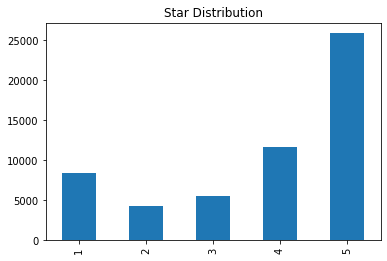

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot for the training data
train_review_df["stars"].value_counts().sort_index().plot(kind="bar")
plt.title("Star Distribution")
plt.show()

We can note that we have an uneven class balance in our dataset, with many 5-star reviews.